In [ ]:
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed

import matplotlib.pyplot as plt
from sklearn.svm import SVC
from rsq import SVCEnsemble, AgglomerativeClassifier

def stratified_sample(y, p=0.67, replace=False):
    unique_y, counts = np.unique(y, return_counts=True)
    n_per_class = np.array([int(np.math.floor(p*c)) for c in counts])
    n_per_class = np.array([max([npc, 1]) for npc in n_per_class])
    
    inds = [np.random.choice(np.where(y == unique_y[i])[0], size=npc, replace=replace) for i, npc in enumerate(n_per_class)]
    
    return np.concatenate(inds)

In [ ]:
def gem(x, p=1):
    """ generalized mean pooling -- interpolation between mean and max """
    nobs, ndim = x.shape
    
    y = np.zeros(ndim)
    for r in range(nobs):
        for c in range(ndim):
            y[c] += x[r,c] ** p
    
    y /= nobs
    
    for c in range(ndim):
        y[c] = y[c] ** (1 / p)
    
    return y

In [ ]:
def few_shot_gaussians(n, d, n_classes=2, type2_var=0.5, var=1, n_labels_per_class=1, n_test=100, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
                
    means = np.random.multivariate_normal(np.zeros(d), type2_var * np.eye(d), size=int(n_classes))
            
    data = np.concatenate([np.random.multivariate_normal(mean, var*np.eye(d), size=n) for mean in means])
    latent_labels = np.concatenate([i*np.ones(n) for i in range(n_classes)])
    
    data_test = np.concatenate([np.random.multivariate_normal(mean, var*np.eye(d), size=n_test) for mean in means])
    y_test = np.concatenate([i*np.ones(n_test) for i in range(n_classes)])
    
    shuf = np.random.choice(n_classes*n, n_classes*n, replace=False)
    data, latent_labels = data[shuf], latent_labels[shuf]
    
    known_labels = -1 * np.ones(n_classes*n)
    labeled_inds = [np.where(latent_labels == i)[0][:n_labels_per_class] for i in range(n_classes)]
    
    for i, inds in enumerate(labeled_inds):
        known_labels[inds] = i
                
    return data, known_labels, latent_labels, data_test, y_test

In [ ]:
from numba import jit
from sklearn.cluster import AgglomerativeClustering


@jit(nopython=True)
def get_tree_distances(n, decision_paths, labeled_inds, counts):
    tree_distances = np.zeros((n, len(labeled_inds)))

    for i in range(n):
        temp_path1=decision_paths[i, :counts[i]]

        for j in range(len(labeled_inds)):
            temp_path2=decision_paths[labeled_inds[j], :counts[labeled_inds[j]]]

            for k in range(counts[j]):    
                if np.sum(temp_path2[k] == temp_path1) > 0:
                    path1_ind = np.argwhere(temp_path1 == temp_path2[k])[0]

                    tree_distances[i,j] = (k + path1_ind[0] + 2) / 2
                    break
                tree_distances[i,j] = (counts[i] + counts[labeled_inds[j]]) / 2
                

    return tree_distances
    
    
@jit(nopython=True)
def get_decision_paths(n, children_array):
    ind_to_path_array = np.zeros((n, n))
    ind_to_path_array[:, 0] = np.arange(n, dtype=np.int32)
    counts = np.ones(n, dtype=np.int32)

    for i in range(children_array.shape[0]):
        node_id = i + n
        left = children_array[i,0]
        right = children_array[i,1]
                        
        for k in range(n):
            if left == ind_to_path_array[k, counts[k]-1] or right == ind_to_path_array[k, counts[k]-1]:
                ind_to_path_array[k, counts[k]] = node_id
                counts[k] += 1
                                
    return ind_to_path_array, counts


class NewAgglomerativeClassifier:
    def __init__(self, n_clusters=2, affinity='cosine', linkage='average',
                n_neighbors=1,
                 max_tree_distance=None,
                 soft_max_multiplier=10,
                 gem_p=1,
                classes=None):
        
        self.n_clusters = n_clusters
        self.affinity = affinity
        self.linkage = linkage
        
        self.n_neighbors = n_neighbors
                
        self.classes_ = classes
        
        self.max_tree_distance=max_tree_distance
        self.soft_max_multiplier=soft_max_multiplier
        
        self.gem_p = gem_p
        
        
    def fit(self, X, y):
        self.n, d = X.shape

        self.labeled_inds = np.where(y != -1)[0]
                
        if self.classes_ is None:
            self.classes_ = np.unique(y[self.labeled_inds])
            
        if -1 in self.classes_:
            self.classes_ = self.classes_[1:]
                        
        self.model = AgglomerativeClustering(n_clusters=self.n_clusters, 
            affinity=self.affinity, 
            linkage=self.linkage, 
            compute_full_tree=True
            )
        self.model.fit(X)
                    
        self.nn = NearestNeighbors(n_neighbors=self.n_neighbors, metric=self.affinity)
        self.nn.fit(X)
        
        labeled_inds_by_class = [np.where(y[self.labeled_inds] == c)[0] for c in self.classes_]
        decision_paths, counts = get_decision_paths(self.n, self.model.children_)
        
        self._get_tree_distances(decision_paths, counts)        
        self._get_similarities_to_classes(labeled_inds_by_class)
        
                                    
    def _get_tree_distances(self, decision_paths, counts):
        self.tree_distances = get_tree_distances(self.n, decision_paths, self.labeled_inds, counts)
        self.tree_distances = np.log(self.tree_distances) + 1
        self.tree_distances = 1 / self.tree_distances
        self.tree_distances = softmax(self.soft_max_multiplier * self.tree_distances, axis=0)
        
        
    def _get_similarities_to_classes(self, labeled_inds_by_class):
        self.similarities_to_classes = np.zeros((self.n, len(self.classes_)))
        
        for i, ibc in enumerate(labeled_inds_by_class):
            self.similarities_to_classes[:, i] = gem(self.tree_distances[:, ibc].T, p=self.gem_p)
                                              
        self.similarities_to_classes = softmax(self.similarities_to_classes, axis=1)
        
        
    def predict_proba(self, X):
        _, neighbor_inds = self.nn.kneighbors(X)
        scores = np.mean(self.similarities_to_classes[neighbor_inds], axis=1)
        return softmax(scores, axis=1)
    
    
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), axis=1)]

In [15]:
0 == np.array([0,1,2])

array([ True, False, False])

In [ ]:
import numpy as np

from sklearn.cluster import AgglomerativeClustering 
from sklearn.neighbors import NearestNeighbors
from sklearn.random_projection import GaussianRandomProjection

from scipy.special import softmax

import itertools


class AgglomerativeEnsemble:
    def __init__(self, n_estimators=50, 
                 p_inbag=0.67, 
                 projector=None, projection_kwargs={},
                 classes=None,
                 affinity='cosine', linkage='average',
                 n_neighbors=1,max_tree_distance=None,
                 gem_p=1,
                 n_jobs=1):

        self.n_estimators=n_estimators
        self.p_inbag=p_inbag
        
        if projector is "gaussian":
            self.projector=GaussianRandomProjection
        else:
            self.projector=projector

        self.projection_kwargs=projection_kwargs
        
        self.classes_=classes
            
        self.affinity=affinity
        self.linkage=linkage
        self.n_neighbors=n_neighbors
        self.max_tree_distance=max_tree_distance

        self.n_jobs=n_jobs
        self.ensemble = []
    
        
    def fit(self, X, y):
        self.unlabeled_inds = np.where(y == -1)[0].astype(int)
        self.labeled_inds = np.where(y != -1)[0].astype(int)
        
        if self.classes_ is None:
            self.classes_ = np.unique(y)

        if -1 in self.classes_:
            self.classes_ = self.classes_[1:]
                             
        condensed_func = lambda x: self._train_agg_class(X, y, stratified=True)
        func_tuples = np.zeros(self.n_estimators)
                
        self.ensemble = Parallel(n_jobs=self.n_jobs)(delayed(condensed_func)(tuple_) for tuple_ in func_tuples)
            

    def _train_agg_class(self, X, y, stratified=True):                
        if len(self.labeled_inds) == len(y):
            all_supervised=True
        else:
            all_supervised=False

        if self.p_inbag >= 1:
            self.p_inbag=1
            replace=False
        else:
            replace=True
  

        sbag_inds = stratified_sample(y[self.labeled_inds], p=self.p_inbag, replace=False)
        if all_supervised:
            bag_inds = sbag_inds
        else:
            ssbag_inds = np.random.choice(len(self.unlabeled_inds), size=int(X.shape[0]*0.67), replace=True)
            bag_inds = np.concatenate((self.labeled_inds[sbag_inds], ssbag_inds))
        

        agg_class = ProjectionAgglomerativeClassifier(affinity=self.affinity, linkage=self.linkage,
            n_neighbors=self.n_neighbors,
            max_tree_distance=self.max_tree_distance,
            classes=self.classes_)

        agg_class.fit(X[bag_inds], y[bag_inds])
                
        return agg_class
    
    
    def predict_proba(self, X):
        return np.mean([agg_class.predict_proba(X) for agg_class in self.ensemble], axis=0)
    
    def votes(self, X):
        return  
        
        
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

[-1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  0. -1. -1.
 -1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  0. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  0. -1. -1. -1. -1.
 -1.  0. -1. -1.  0. -1. -1. -1. -1.  1.  1. -1.  1. -1. -1.  1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1.
  1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  0. -1. -1. -1. -1. -1. -1. -1.
  1. -1. -1.  0. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  0.
  0.  1. -1.  0. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1.  0. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1.  0.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1.  0. -1. -1.  0. -1

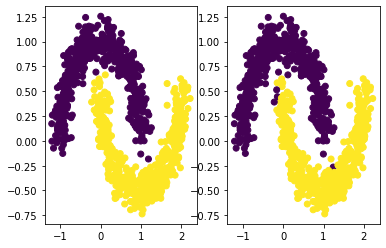

In [ ]:
from sklearn.datasets import make_moons
# np.random.seed(2)


nus = clf.predict_proba(X)
y_hat=clf.predict(X)

print(y_)

ax[1].scatter(X[:, 0], X[:, 1], c=y_hat)

In [270]:
n=3000
X, y = make_moons(n, noise=0.1)

n_labeled=50
inds = np.random.choice(len(y), n_labeled, replace=False).astype(np.int32)

y_ = -1 * np.ones(n)
y_[inds] = y[inds]

In [271]:
%%time
clf=AgglomerativeClassifier(affinity='euclidean', linkage='single', n_neighbors=int(np.math.log(n)), gem_p=16)
clf.fit(X, y_)
(clf.predict(X) == y).mean()

KeyboardInterrupt: 

In [269]:
%%time
clf=NewAgglomerativeClassifier(affinity='euclidean', linkage='single', n_neighbors=int(np.math.log(n)), gem_p=16)
clf.fit(X, y_)
(clf.predict(X) == y).mean()

CPU times: user 5.29 ms, sys: 0 ns, total: 5.29 ms
Wall time: 4.03 ms


1.0

In [249]:
clf.tree_distances

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [272]:
%%time
nn = NearestNeighbors(metric='euclidean')
nn.fit(X)

CPU times: user 1.33 ms, sys: 0 ns, total: 1.33 ms
Wall time: 1.23 ms


NearestNeighbors(metric='euclidean')

In [273]:
%%time
clu=AgglomerativeClustering(affinity='euclidean', linkage='single')
clu.fit(X)

CPU times: user 52.5 ms, sys: 2 µs, total: 52.5 ms
Wall time: 51.6 ms


AgglomerativeClustering(linkage='single')

In [282]:
clu.children_.shape

(2999, 2)

(array([  18.,   61.,   74.,   90.,  107.,  117.,  214.,  795., 1177.,
         347.]),
 array([  2. ,  20.7,  39.4,  58.1,  76.8,  95.5, 114.2, 132.9, 151.6,
        170.3, 189. ]),
 <BarContainer object of 10 artists>)

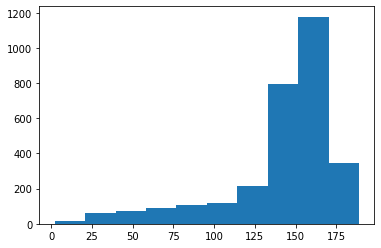

In [284]:

plt.hist(counts)

In [281]:
np.mean(counts) 

141.65866666666668

In [289]:
np.min([1,0])

0

In [285]:
from rsq.agglomerative_helpers import get_decision_paths as gdp
from 

In [283]:
%%time
decision_paths, counts = get_decision_paths(n, clu.children_)

CPU times: user 26.2 ms, sys: 4 ms, total: 30.2 ms
Wall time: 30 ms


In [286]:
_, counts2 = gdp(n, clu.children_)

In [288]:
np.max(clu.children_)

5997

(array([  18.,   61.,   74.,   90.,  107.,  117.,  214.,  795., 1177.,
         347.]),
 array([  2. ,  20.7,  39.4,  58.1,  76.8,  95.5, 114.2, 132.9, 151.6,
        170.3, 189. ]),
 <BarContainer object of 10 artists>)

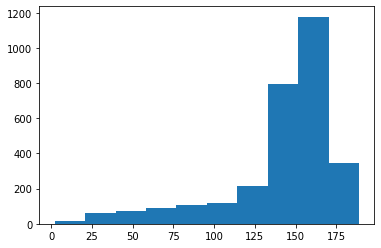

In [287]:
plt.hist(counts2)

In [275]:
%%time
get_tree_distances(n, decision_paths, inds, counts)

CPU times: user 1.48 s, sys: 5.31 ms, total: 1.49 s
Wall time: 1.48 s


array([[134. , 141. ,  28.5, ..., 139. ,  29. ,  32.5],
       [ 36.5,   9.5, 160. , ...,  41.5, 142.5, 164. ],
       [ 28. ,  35. , 128.5, ...,  33. , 111. , 132.5],
       ...,
       [  7. ,  37. , 153.5, ...,   8. , 136. , 157.5],
       [ 27.5,  34.5, 142. , ...,  32.5, 124.5, 146. ],
       [ 10. ,  45. , 161.5, ...,  20. , 144. , 165.5]])

In [212]:
%%time
no_jit_get_tree_distances(n, decision_paths, inds, counts)

CPU times: user 1min 49s, sys: 320 ms, total: 1min 49s
Wall time: 1min 48s


/home/hhelm/venvs/apu/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


In [12]:
class ProjectionAgglomerativeClassifier(AgglomerativeClassifier):
    def __init__(self, 
                 projector=None, projection_kwargs={},
                 n_clusters=2, affinity='cosine', linkage='average',
                 n_neighbors=1,
                 max_tree_distance=None,
                 soft_max_multiplier=1,
                classes=None):
        
        if projector is "gaussian":
            self.projector=GaussianRandomProjection
        else:
            self.projector=projector

        self.projection_kwargs=projection_kwargs
        
        super().__init__(n_clusters = n_clusters, affinity = affinity, linkage = linkage,
                         n_neighbors = n_neighbors, classes = classes, max_tree_distance=max_tree_distance,
                         soft_max_multiplier=soft_max_multiplier)
        
        
    def fit(self, X, y):
        if self.projector is None:
            super().fit(X, y)
        else:
            self.projector = self.projector(**self.projection_kwargs)
            self.projector.fit(X)
            super().fit(self.projector.transform(X), y)
  

    def predict_proba(self, X):
        if self.projector is None:
            return super().predict_proba(X)
        else:
            self.projector = self.projector(**self.projection_kwargs)
            self.projector.fit(X)
            return super().predict_proba(self.projector.transform(X))

    
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), axis=1)]

In [118]:
@jit(nopython=True)
def get_decision_paths(n, children_array):
    ind_to_path_array = np.zeros((n, n))
    ind_to_path_array[:, 0] = np.arange(n, dtype=np.int32)
    counts = np.ones(n, dtype=np.int32)

    for i in range(children_array.shape[0]):
        node_id = i + n
        left = children_array[i,0]
        right = children_array[i,1]
                        
        for k in range(n):
            if left == ind_to_path_array[k, counts[k]-1] or right == ind_to_path_array[k, counts[k]-1]:
                ind_to_path_array[k, counts[k]] = node_id
                counts[k] += 1
                                
    return ind_to_path_array, counts

In [187]:
@jit(nopython=True)
def get_tree_distances(n, decision_paths, labeled_inds, counts):
    tree_distances = np.zeros((n, len(labeled_inds)))

    for i in range(n):
        temp_path1=decision_paths[i, :counts[i]]

        for j in range(len(labeled_inds)):
            temp_path2=decision_paths[labeled_inds[j], :counts[labeled_inds[j]]]

            for k in range(counts[j]):    
                if np.sum(temp_path2[k] == temp_path1) > 0:
                    path1_ind = np.argwhere(temp_path1 == temp_path2[k])[0]

                    tree_distances[i,j] = (k + path1_ind[0] + 2) / 2
                    break

    tree_distances = 1 / tree_distances
#     tree_distances = softmax(tree_distances, axis=0)

In [124]:
%time
get_tree_distances(n, arrays[0], inds, arrays[1])

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 11 µs


In [168]:
np.where(np.array([1,2,3,4]) == 3)[0][0]

2

In [173]:
np.nonzero(np.array([1,2,3,4]) == 3)

(array([2]),)

In [93]:
%time
dicts= _get_decision_paths(n, children)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 11.2 µs


In [117]:
%time
arrays = get_decision_paths(n, children)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.78 µs


In [106]:
%time
jitted = jit_get_decision_paths(n, children)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.3 µs
